# Hurricane Florence

# Overlay - Hurricane Florence
For this example, we want to see a real-life application of a join. Our final product is intended to be a map of the US, with the hurricane Florence path on top of it, where we have highlighted the states hit by hurricane Florence in blue.

We start by importing as before and repeating the work we did from the last lesson to plot the hurricane path on top of the map of the US. Remember, the cell to translate hurricane Florence data to a `GeoDataFrame` is necessary, but not important to understand how we do it. As a brief recap:
* We load in the US dataset into a variable called `country` and filter out Hawaii and Alaska for visibility
* We load in the hurricane Florence dataset and convert its `Lat` and `Long` columns to a single column of Point geometries. We then convert that `DataFrame` with a geometry column (called `coordinates`) to a `GeoDataFrame` that is aware of that geometry.
* We plot the two on top of each other by making a `Figure` and `Axes` and having both `GeoDataFrames` draw themselves on that one `Axes` `ax`.

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# A special command for Notebooks to get the plots inline
%matplotlib inline 

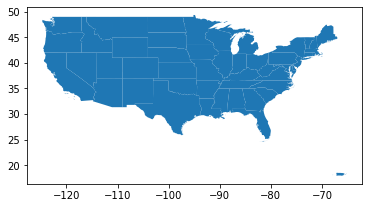

In [3]:
# Load in US Data
country = gpd.read_file("gz_2010_us_040_00_5m.json")
country = country[(country['NAME'] != 'Alaska') & (country['NAME'] != 'Hawaii')]
country.plot()

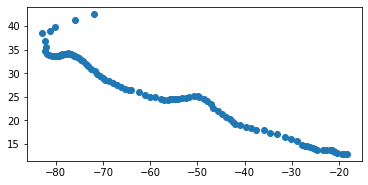

In [4]:
from shapely.geometry import Point

# Load in Florence data
florence = pd.read_csv('stormhistory.csv')
florence['coordinates'] = [Point(-long, lat) for long, lat in 
                           zip(florence['Long'], florence['Lat'])]
florence = gpd.GeoDataFrame(florence, geometry='coordinates')
# Advanced: Need to specify map projection points so we can join them later
florence.crs = country.crs 

florence.plot()

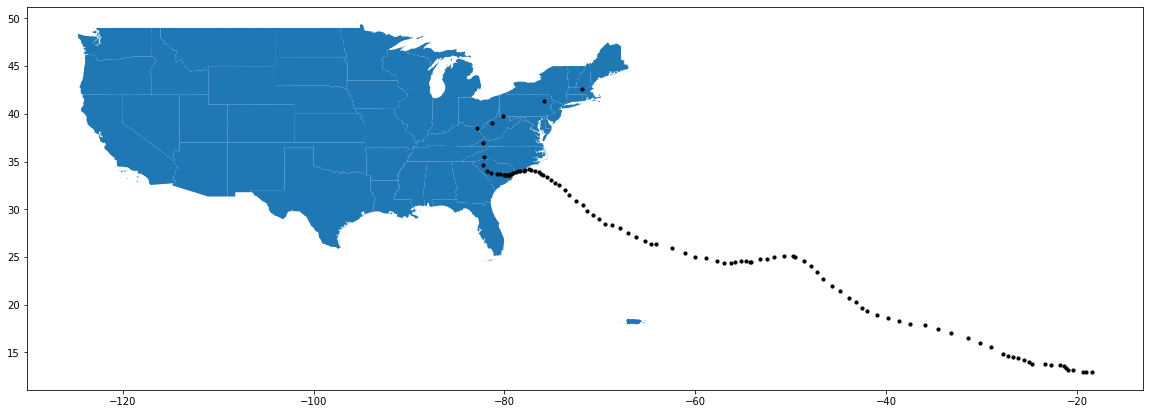

In [5]:
# Plot both on top of each other
fig, ax = plt.subplots(1, figsize=(20,10))
country.plot(ax=ax)
florence.plot(ax=ax, color='#000000', markersize=10)

# Joining Geospatial Data

So if our goal is to highlight the states that were hit by hurricane Florence, we will need some way to "line up" the two datasets so we know which rows in the US dataset correspond to rows in the Florence dataset if they overlap.

Given what we learned in this lesson, this might give you an idea that we want to use a join somehow to do this, and that intuition is exactly right! Whenever you have this task of trying to "line up" two datasets, the join is usually the tool for the job. What type of join will we want to use? Well let's just start by finding the states that do intersect, so we will want to use some type of inner-join so that we can find rows from both tables that overlap.

Using that intution, you would think that we need to call the `merge` function like we saw prevously. You might try to write something like:
```python
country.merge(florence, left_on='geometry', right_on='coordinates', how='inner')
```

However, this won't work! The reason is a subtle fact from how `merge` works. Remember, `merge` will join two rows together if the value in `left_on` from the left dataset **equals** the value of `right_on` in the right dataset. Notice, this would mean that the geometry from the US (a `Polygon` or `MultiPolygon`) would somehow have to be equal to a `Point`! This is just not possible since they represent completely different shapes.

Instead, we need to have some kind of special semantics for joining data based on geometries. In this context, we don't want to join two rows if they have the exact same geometry, but rather if they **intersect** (or overlap) somehow. This idea of having more complex semantics for how to join rows based on geospatial information is exactly why `geopandas` as a special type of join called a "spatial join", or `sjoin` for short.

The semantics for doing a spacial join or very similar to `pandas`' `merge`, with two key differences:
* You don't need to specify which columns to join on. `GeoDataFrames` know which column represents its geometry, so it will just use that column.
* You have to specify what it means for two geometries to "match" (i.e., if they should be joined together) using the `op` paramter. The most common (and default) is `'intersects'` for if the two geometries intersect in any way. If you're curious, you can see other types join semantics in the `sjoin` [documentation](https://geopandas.org/reference/geopandas.sjoin.html).

To do this special spatial join uses the syntax below. Notice that it is slightly different since you call it from the `gpd` module rather than on a specific `GeoDataFrame`.

In [8]:
affected_states = gpd.sjoin(country, florence, how='inner', op='intersects')

print('Num Rows', len(affected_states))
display(affected_states.head())

Num Rows 25


,GEO_ID,STATE,NAME,LSAD,CENSUSAREA,geometry,index_right,AdvisoryNumber,Date,Lat,Long,Wind,Pres,Movement,Type,Name,Received,Forecaster
17,0400000US21,21,Kentucky,,39486.338,"MULTIPOLYGON (((-89.48511 36.49769, -89.49254 ...",100,73,09/17/2018 11:00,38.5,82.9,25,1008,NE at 15 MPH (40 deg),Tropical Depression,FLORENCE,09/17/2018 10:59,NaN
21,0400000US25,25,Massachusetts,,7800.058,"MULTIPOLYGON (((-70.82740 41.60207, -70.82373 ...",104,77,09/18/2018 11:00,42.6,71.9,25,1006,ENE at 25 MPH (70 deg),Post-Tropical Cyclone,Florence,09/18/2018 11:14,Carbin
33,0400000US37,37,North Carolina,,48617.905,"MULTIPOLYGON (((-75.75377 35.19961, -75.74522 ...",83,62,09/14/2018 17:00,34.0,78.6,70,972,W at 3 MPH (270 deg),Tropical Storm,Florence,09/14/2018 16:45,Stewart
33,0400000US37,37,North Carolina,,48617.905,"MULTIPOLYGON (((-75.75377 35.19961, -75.74522 ...",82,61A,09/14/2018 14:00,34.0,78.4,75,968,W at 5 MPH (270 deg),Hurricane,Florence,09/14/2018 13:54,Stewart
33,0400000US37,37,North Carolina,,48617.905,"MULTIPOLYGON (((-75.75377 35.19961, -75.74522 ...",81,61,09/14/2018 11:00,34.0,78.0,80,958,WSW at 3 MPH (245 deg),Hurricane,Florence,09/14/2018 10:42,Stewart


Notice that the number of rows is 25, because the same state will appear every time it intersects with a row from Florence! This won't cause a problem, but it's important to mention that `sjoin` has the exact same join mechanics as `merge` (i.e., find all pairs of rows that "match"), the only difference is it changes what the definition of "match" means in the context of geospatial data.

As a techincal note, the `sjoin` preserves the geometry of the left dataset. So in our example above, since we joined with `country` on the left, the resulting DataFrame will keep the `country` geometry column.

Now that we have our states affected by the hurricane, we are now able to plot them. *All* that's left is to plot these states on the map to highlight them. To do this, we take a similar approach as your earlier practice problem where we plot the following elements in the following order on one set of `Axes`.
* The entire US in grey (`color='#EEEEEE'`) with a white border (`edgecolor='#FFFFFF'`).
* The affected states in blue (default) with a white border.
* The hurricane points in black (`color='#000000'`) with a smaller size of the dot (`markersize=10`).

All of this code is below.

> Optional: If you're curios the color codes are using this thing called a "hexidecimal" value to specify what the color is. This has to come from the fact that computers commonly store colors as RGB or "Red, Green, Blue" format. This means each color is specified by how much red, how much blue, and how much green is in the color by specifying a number betwee 0 and 255 for each. These strings are using a special number-scheme called "hexidecimal" to write these three numbers between 0 and 255 compactly in one string. The gist of the format is each color is specified by two characters (order R, then G, then B) where `00` is the lowest and `FF` is the highest. 

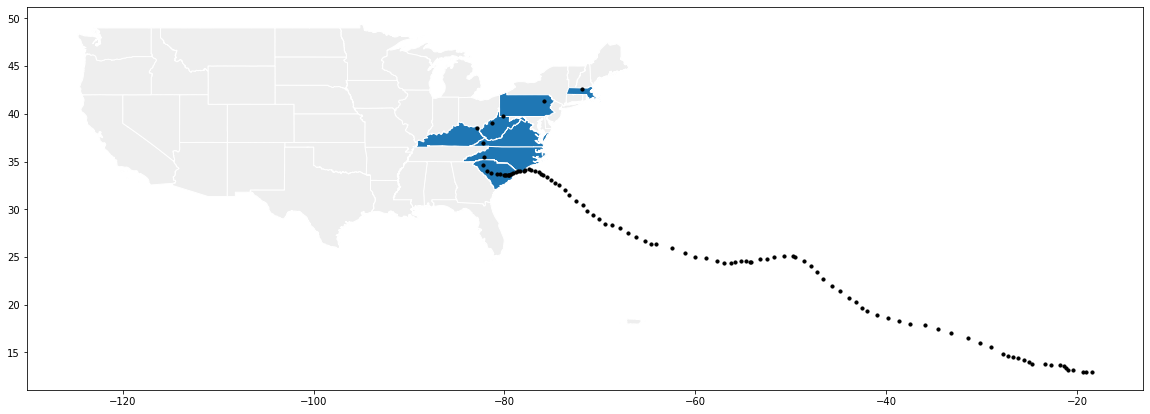

In [9]:
fig, ax = plt.subplots(1, figsize=(20, 10))

country.plot(ax=ax, color='#EEEEEE', edgecolor='#FFFFFF')

affected_states.plot(ax=ax, edgecolor='#FFFFFF')

florence.plot(ax=ax, color='#000000', markersize=10)

And there is our graph! Notice the "hard" part about this is actually not the plotting at all! The plot itself doesn't use anything more advanced than what we saw in the previous lesson! Instead, what is difficult to do was to get the right data so that we can plot it by using `sjoin`.

In the next lesson, we will how this spatial join is actually implemented fairly efficiently using a special data structure called a "tree".